In [64]:
import tensorflow as tf
import tensorflow_datasets as tfds
import keras
from keras.models import Sequential
from keras.layers import Dense, Reshape, BatchNormalization, LeakyReLU, UpSampling2D, Conv2D, ReLU, Flatten, Dropout
import matplotlib.pyplot as plt
import torch
import torchvision

In [42]:
# Function to normalize images
def normalize_image(image, mean=0.5, std=0.5):
    image = tf.image.convert_image_dtype(image, tf.float32)  # Converts [0, 255] to [0, 1]
    image = (image - mean) / std  # Normalize to [-1, 1]
    return image

# Function to preprocess the dataset
def preprocess_data(image, label):
    image = normalize_image(image)
    return image, label

# Example with MNIST dataset
dataset = tfds.load('FashionMNIST', split='train', as_supervised=True, batch_size=32)

# Apply preprocessing
ds1 = dataset.map(preprocess_data, num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Set up DataLoader
batch_size = 32
# dataloader = dataset.shuffle(10000).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)


In [31]:
ds = tfds.load('FashionMNIST', split='train', shuffle_files=True)
ds1 = ds.batch(32, drop_remainder=True)

In [43]:
len(ds1)

1875

In [44]:
latent_dim = 100
generator = Sequential()

# Input layer
generator.add(Dense(128 * 7 * 7, input_dim=100))
generator.add(ReLU())
generator.add(Reshape((7, 7, 128)))

# Upsampling layers
generator.add(UpSampling2D(size=(2, 2)))
generator.add(Conv2D(128, kernel_size=(3, 3), padding='same'))
generator.add(BatchNormalization(momentum=0.78))
generator.add(ReLU())

generator.add(UpSampling2D(size=(2, 2)))
generator.add(Conv2D(64, kernel_size=(3, 3), padding='same'))
generator.add(BatchNormalization(momentum=0.78))
generator.add(ReLU())

# Output layer
generator.add(Conv2D(1, kernel_size=(3, 3), activation='tanh', padding='same'))

# Display the generator architecture
generator.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 6272)              633472    
                                                                 
 re_lu_10 (ReLU)             (None, 6272)              0         
                                                                 
 reshape_4 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d_7 (UpSamplin  (None, 14, 14, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 14, 14, 128)       147584    
                                                                 
 batch_normalization_13 (Ba  (None, 14, 14, 128)       512       
 tchNormalization)                                    

In [45]:
discriminator = Sequential()

# Input layer
discriminator.add(Conv2D(32, kernel_size=(3, 3), strides=(2, 2), padding='same', input_shape=(28, 28, 1)))
discriminator.add(LeakyReLU(alpha=0.2))

# Hidden layers
discriminator.add(Conv2D(64, kernel_size=(3, 3), strides=(2, 2), padding='same'))
discriminator.add(BatchNormalization(momentum=0.82))
discriminator.add(LeakyReLU(alpha=0.2))

discriminator.add(Conv2D(128, kernel_size=(3, 3), strides=(2, 2), padding='same'))
discriminator.add(BatchNormalization(momentum=0.82))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.25))

discriminator.add(Conv2D(256, kernel_size=(3, 3), strides=(2, 2), padding='same'))
discriminator.add(BatchNormalization(momentum=0.8))
discriminator.add(LeakyReLU(alpha=0.25))
discriminator.add(Dropout(0.25))

discriminator.add(Flatten())

# Output layer
discriminator.add(Dense(1, activation='sigmoid'))

# Display the discriminator architecture
discriminator.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_23 (Conv2D)          (None, 14, 14, 32)        320       
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 14, 14, 32)        0         
                                                                 
 conv2d_24 (Conv2D)          (None, 7, 7, 64)          18496     
                                                                 
 batch_normalization_15 (Ba  (None, 7, 7, 64)          256       
 tchNormalization)                                               
                                                                 
 leaky_re_lu_11 (LeakyReLU)  (None, 7, 7, 64)          0         
                                                                 
 conv2d_25 (Conv2D)          (None, 4, 4, 128)         73856     
                                                      

In [48]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set the number of epochs and batch size for training
epochs = 10
batch_size = 32

optimizer_G = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
optimizer_D = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

# Loss function
cross_entropy = tf.keras.losses.BinaryCrossentropy()

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return (real_loss + fake_loss) / 2

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# Set the label for real and fake images
real_labels = np.ones((batch_size, 1))
fake_labels = np.zeros((batch_size, 1))

for epoch in range(epochs):
  i=0
  for batch in ds1:
    # Generate a batch of fake images
    z = np.random.normal(0,1,(batch_size, latent_dim))
    with tf.GradientTape() as d_tape, tf.GradientTape() as g_tape:
      fake_images = generator(z, training=True)

      real = discriminator(batch[0], training=True)
      fake = discriminator(fake_images, training=True)

      d_loss = discriminator_loss(real, fake)
      g_loss = generator_loss(fake)

    d_grad = d_tape.gradient(d_loss, discriminator.trainable_variables)
    g_grad = g_tape.gradient(g_loss, generator.trainable_variables)

    # Update weights
    optimizer_D.apply_gradients(zip(d_grad, discriminator.trainable_variables))
    optimizer_G.apply_gradients(zip(g_grad, generator.trainable_variables))

    if (i + 1) % 100 == 0:
      print(f"Epoch [{epoch+1}/{epochs}]\
      Batch [{i+1}/{len(ds1)}] DLoss: {d_loss.numpy():.4f} GLoss: {g_loss.numpy():.4f}")
    i+=1

# Save the trained generator model
generator.save('/path/to/trained_generator.h5')

Epoch [1/10]      Batch [100/1875] DLoss: 0.2989 GLoss: 1.5956
Epoch [1/10]      Batch [200/1875] DLoss: 0.3999 GLoss: 2.4884
Epoch [1/10]      Batch [300/1875] DLoss: 0.1903 GLoss: 2.8175
Epoch [1/10]      Batch [400/1875] DLoss: 0.1946 GLoss: 3.0018
Epoch [1/10]      Batch [500/1875] DLoss: 0.1692 GLoss: 2.5983
Epoch [1/10]      Batch [600/1875] DLoss: 0.2664 GLoss: 2.4058
Epoch [1/10]      Batch [700/1875] DLoss: 0.2806 GLoss: 2.5407
Epoch [1/10]      Batch [800/1875] DLoss: 0.8667 GLoss: 0.4151
Epoch [1/10]      Batch [900/1875] DLoss: 0.4626 GLoss: 1.9596
Epoch [1/10]      Batch [1000/1875] DLoss: 0.3846 GLoss: 1.4661
Epoch [1/10]      Batch [1100/1875] DLoss: 0.2867 GLoss: 2.2606
Epoch [1/10]      Batch [1200/1875] DLoss: 0.6720 GLoss: 1.0748
Epoch [1/10]      Batch [1300/1875] DLoss: 0.3515 GLoss: 2.2755
Epoch [1/10]      Batch [1400/1875] DLoss: 0.2380 GLoss: 1.5684
Epoch [1/10]      Batch [1500/1875] DLoss: 0.4685 GLoss: 3.2156
Epoch [1/10]      Batch [1600/1875] DLoss: 0.5867

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 53ms/step
(9, 28, 28, 1)
torch.Size([3, 92, 92])


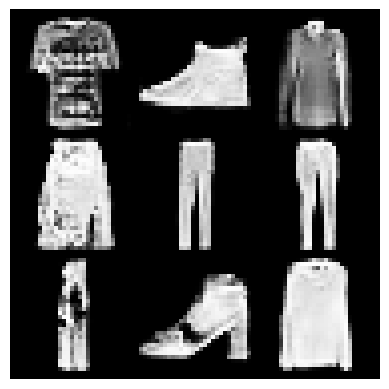

In [67]:
  z = tf.random.normal((9, latent_dim))
  generated = generator.predict(z)
  print(generated.shape)
  grid = torchvision.utils.make_grid(np.transpose(torch.tensor(generated), (0, 3, 2, 1)),nrow=3, normalize=True)
  print(grid.shape)

  plt.imshow(np.transpose(grid, (2, 1, 0)))
  plt.axis("off")
  plt.show()

In [60]:
generator.save('FashionMNISTGenerator.keras')

In [58]:
discriminator.save('FashionMNISTDiscriminator.keras')